Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/wei-tianyu/deep-remote-prior
!mv deep-remote-prior/* ./

Cloning into 'deep-remote-prior'...
remote: Enumerating objects: 472, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 472 (delta 237), reused 451 (delta 216), pack-reused 0
Receiving objects: 100% (472/472), 115.71 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7398333249060644560
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12320437210964435149
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# Import libs

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import time

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio
from utils.denoising_utils import *
from threading import Thread
import queue
from models.skip import skip

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time

from skimage.restoration import denoise_nl_means

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255

random_seed = 545
torch.manual_seed(random_seed)

In [ ]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = '545test_set/denoising/Baboon.png'
picname = 'Baboon'

# Constants

In [ ]:
SIGMA = 25
# graphs labels:
X_LABELS = ['Iterations']*3
Y_LABELS = ['PSNR between x and net (db)', 'PSNR with original image (db)', 'loss']

# Algorithm NAMES (to get the relevant image: use data_dict[alg_name].img)
# for example use data_dict['Clean'].img to get the clean image
ORIGINAL = 'Clean'
CORRUPTED = 'Noisy'
NLM = 'NLM'
DIP_NLM = 'DRED (NLM)'


# Load image

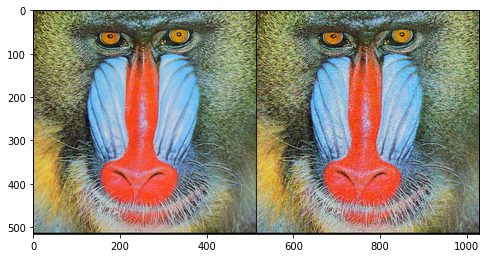

In [ ]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
else:
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
#else:
#    assert False

# Setup

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
#show_every = 100
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

else:
    num_iter = 3001
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Generate data dict

In [ ]:
def load_image(img_np, img_noisy_np, sigma=25, plot=False):
    """ 
        fname - input file name
        d - Make dimensions divisible by `d`
        sigma - the amount of noise you want to add noise to the image
        Return a numpy image, and a noisy numpy image with sigma selected
    """
    # _, img_np = load_and_crop_image(fclean)
    # if fnoisy is None:
    #     img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma / 255., size=img_np.shape), 0, 1).astype(
    #         np.float32)
    #     # img_noisy_np = pil_to_np(np_to_pil(img_noisy_np)) # making it an image then loading it back to numpy
    # else:
    #     _, img_noisy_np = load_and_crop_image(fnoisy)
    data_dict = {ORIGINAL: Data(img_np), CORRUPTED: Data(img_noisy_np, peak_signal_noise_ratio(img_np, img_noisy_np))}
    if plot:
        plot_dict(data_dict)
    return data_dict

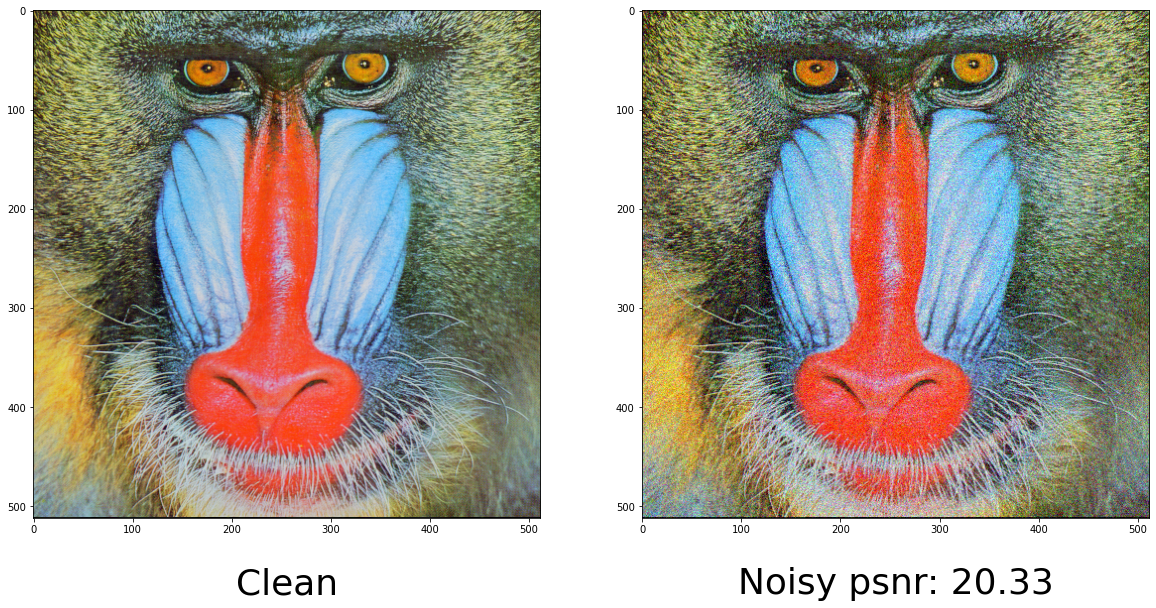

In [ ]:
# load the image and add noise - for real use send same image file to fclean and fnoisy and ignore psnrs
data_dict = load_image(img_np, img_noisy_np, sigma=SIGMA, plot=True)

# The Non Local Means denoiser 

In [ ]:
def non_local_means(noisy_np_img, sigma, fast_mode=True):
    """ get a numpy noisy image
        returns a denoised numpy image using Non-Local-Means
    """ 
    sigma = sigma / 255.
    h = 0.6 * sigma if fast_mode else 0.8 * sigma
    patch_kw = dict(h=h,                   # Cut-off distance, a higher h results in a smoother image
                    sigma=sigma,           # sigma provided
                    fast_mode=fast_mode,   # If True, a fast version is used. If False, the original version is used.
                    patch_size=5,          # 5x5 patches (Size of patches used for denoising.)
                    patch_distance=6,      # 13x13 search area
                    multichannel=False)
    denoised_img = []
    n_channels = noisy_np_img.shape[0]
    for c in range(n_channels):
        denoise_fast = denoise_nl_means(noisy_np_img[c, :, :], **patch_kw)
        denoised_img += [denoise_fast]
    return np.array(denoised_img, dtype=np.float32)

In [ ]:
# Soft Thresholding function
def soft(z, lam): 
  result = z - torch.clamp(z, -lam, lam)
  return result

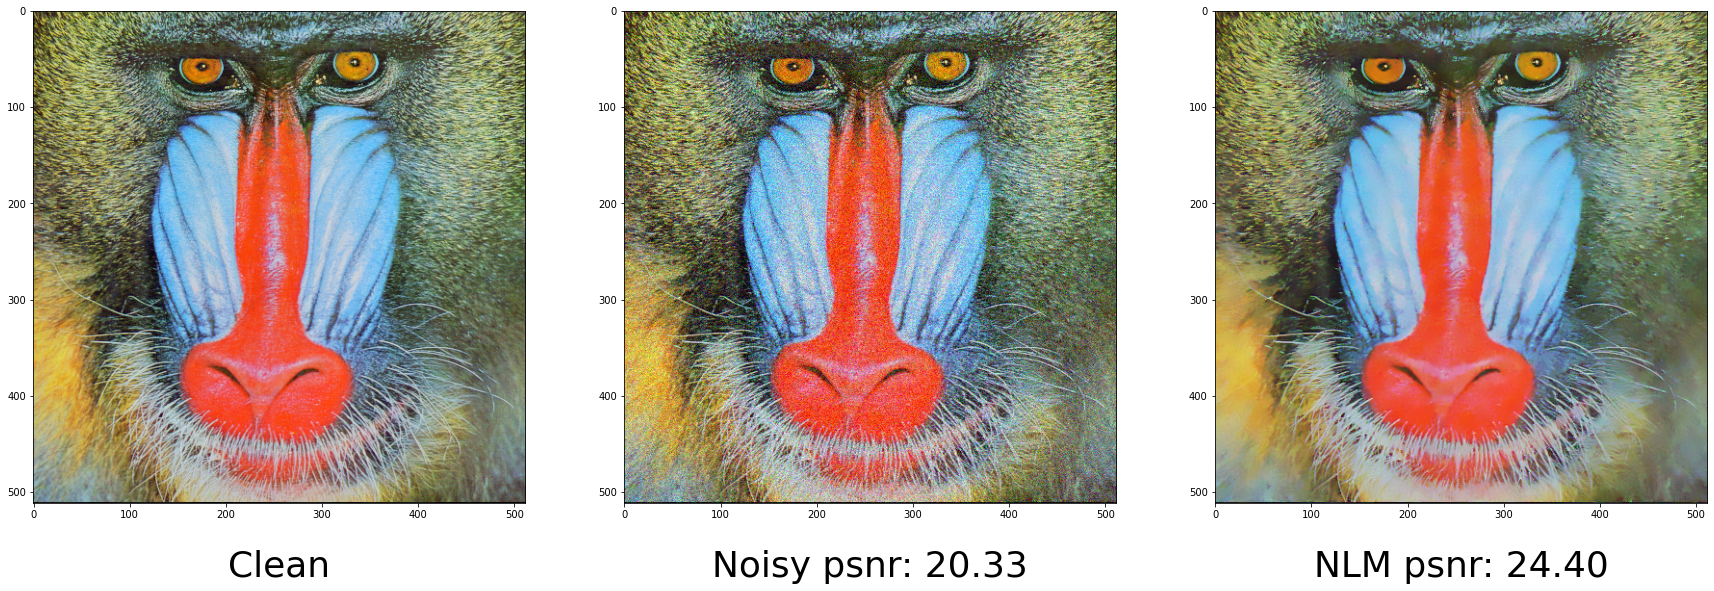

In [ ]:
# Run Non-Local-Means
denoised_img = non_local_means(data_dict[CORRUPTED].img, sigma=SIGMA)
data_dict[NLM] = Data(denoised_img, peak_signal_noise_ratio(data_dict[ORIGINAL].img, denoised_img))
plot_dict(data_dict)

# Optimize

In [ ]:
net_input_saved = net_input.detach().clone()
print(net_input_saved)
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
org_img = data_dict[ORIGINAL].img
admm_iter = 6000
sigma_f = 3
y = data_dict[CORRUPTED].img
x, u = y.copy(), np.zeros_like(y)
# avg, avg2, avg3 = np.rint(y), np.rint(y), np.rint(y)
y_torch = np_to_torch(y).type(dtype)
method = "fixed_point"

filename_gt_sm = 'pdp_gt_sm_' + picname + '.txt'
filename_gt = 'pdp_gt_' + picname + '.txt'
filename_loss = 'pdp_loss_' + picname + '.txt'
filename_time = 'pdp_time_' + picname + '.txt'
t = 0
i = 1

def closure():
    
    #sorry to use such many global vars...
    global i, out_avg, psrn_noisy_last, last_net, net_input, method, org_img, data_dict, non_local_means, admm_iter, sigma_f, y, x, u, y_torch, method, start, t, filename_gt_sm, filename_gt, filename_loss, filename_noisy

    #time
    if (i == 1):
      start = time.time()

    beta=.5
    mu=0.8 * 0.996**i
    lam = 0.003

    denoiser_function = non_local_means
    if org_img is not None:
        psnr_y = peak_signal_noise_ratio(org_img, y)  # get the noisy image psnr


    #initialize f_x
    f_x = x.copy()
    
    #step1: update network
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = soft((1-mu)* net(net_input) + mu * y_torch, mu * lam)
    out_np = torch_to_np(out)
    
    # loss:
    loss_y = mse(out, y_torch)
    #loss_x = torch.norm(out, 2)
    #total_loss = loss_y + loss_x
    total_loss = loss_y
    total_loss.backward()
    time_consuming = time.time() - start
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
        
    curve_psrn_noisy = np.zeros(30)
    curve_psrn_gt = np.zeros(30)
    curve_psrn_gt_sm = np.zeros(30)
    curve_loss = np.zeros(30)

    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        # psrn_noise, psrn_gt, psrn_gt_sm, loss curve
        with open(filename_time, 'a') as f:
          f.write(str(time_consuming)+"\t")
          #f.write("\t")
        with open(filename_gt, 'a') as f:
          f.write(str(psrn_gt)+"\t")
          #f.write("\t")
        with open(filename_gt_sm, 'a') as f:
          f.write(str(psrn_gt_sm)+"\t")
          #f.write("\t")
        with open(filename_loss, 'a') as f:
          f.write(str(total_loss.item())+"\t")
          #f.write("\t")
        print (i, "runtime:", time_consuming)
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),'\n')

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1
    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

tensor([[[[0.0676, 0.0271, 0.0858,  ..., 0.0395, 0.0633, 0.0855],
          [0.0762, 0.0239, 0.0455,  ..., 0.0500, 0.0584, 0.0787],
          [0.0696, 0.0188, 0.0700,  ..., 0.0052, 0.0281, 0.0382],
          ...,
          [0.0146, 0.0905, 0.0857,  ..., 0.0309, 0.0356, 0.0733],
          [0.0166, 0.0760, 0.0655,  ..., 0.0198, 0.0534, 0.0512],
          [0.0921, 0.0291, 0.0846,  ..., 0.0834, 0.0162, 0.0485]],

         [[0.0130, 0.0637, 0.0054,  ..., 0.0422, 0.0934, 0.0051],
          [0.0223, 0.0681, 0.0244,  ..., 0.0812, 0.0431, 0.0996],
          [0.0683, 0.0851, 0.0958,  ..., 0.0524, 0.0013, 0.0132],
          ...,
          [0.0339, 0.0301, 0.0151,  ..., 0.0032, 0.0630, 0.0742],
          [0.0646, 0.0746, 0.0516,  ..., 0.0727, 0.0338, 0.0837],
          [0.0702, 0.0082, 0.0496,  ..., 0.0105, 0.0344, 0.0142]],

         [[0.0973, 0.0187, 0.0761,  ..., 0.0645, 0.0579, 0.0552],
          [0.0732, 0.0211, 0.0234,  ..., 0.0502, 0.0915, 0.0330],
          [0.0843, 0.0370, 0.0106,  ..., 0

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
print(i)

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()